In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

from scipy.signal import savgol_filter
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import seaborn as sns
sns.set_theme(font_scale=1.5)

G = 214 # cm^2-sr , average BARREL geometric factor

# Load BARREL X-ray spectrum and process data

- Altitude: 33.45 km
- Date: 2015-08-13

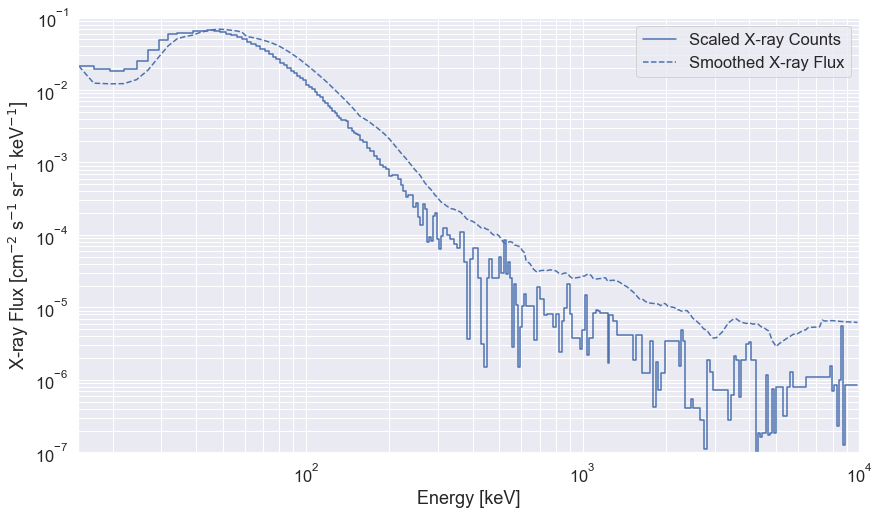

In [49]:
spec   = pd.read_csv('data/BARREL/barrel_xray_spectra.txt', names=['E', 'cts', 'cts_err'], sep=' ')
b_inv  = pd.read_csv('data/BARREL/barrel_elec_spectra.txt', names=['E', 'C'], sep='\s+')

# Divide by geometric factor to estimate flux
spec.cts     /= G
spec.cts_err /= G

# Set negative count bins from electronic offset to nan
spec.cts[spec.cts < 0] = np.nan

# Replace nans with a moving window median filter
windowSize = 9
for i in range(0, len(spec)):
    spec.cts[i*windowSize:(i+1)*windowSize].fillna(np.nanmedian(spec.cts[i*windowSize:(i+1)*windowSize]), 
                                                   inplace=True)

# Replace remaning nans with end value
spec.cts[np.isnan(spec.cts)] = spec.cts[251]

# Smooth with SavGol filter and divide by analytical approximation of 
# NaI efficiency from Akkurt,et al. 2014 
test_spectra = np.hstack([spec.cts[0:25], savgol_filter(spec.cts[25:], 19, 1)]) / \
                        (0.15 + 1e1 / spec.E**0.65)


plt.figure(figsize=(14,8)); plt.grid(True, which='both')
plt.step(spec.E, spec.cts, c='b', label='Scaled X-ray Counts')
plt.plot(spec.E, test_spectra, '--', c='b', label='Smoothed X-ray Flux')


plt.legend()
plt.xlabel('Energy [keV]');
plt.ylabel('X-ray Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.xscale('log')
plt.yscale('log')
plt.xlim(1.5e1, 1e4);
plt.ylim(1e-7, 1e-1);

# Load and process EPP model data

In [50]:
filename = "../data/G4data_mono_discretePAD_0degLat.pkl"

D_mono = pickle.load(open(filename, 'rb'))

Earray   = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
h        = np.linspace(0, 499, 500);
binWidth = np.hstack([np.diff(Earray), np.diff(Earray)[-1]]);
run_list = np.unique([int(x) for x in np.array(list(D_mono.keys()))[:,2]])

LOWLIMIT = 0
RUNLIMIT = len(run_list)
RUNLIMIT = -1

sh = np.shape(D_mono[('photon', 'spectra', 10, 0)][0])

EbinCenters = np.hstack([np.diff(Earray), np.diff(Earray)[-1]])

ang_avg = np.zeros([sh[0], sh[1], len(run_list[LOWLIMIT:RUNLIMIT])])
for j, ene in enumerate(run_list[LOWLIMIT:RUNLIMIT]):
    for i, ang in enumerate(np.arange(0, 70+5, 5)):
        ang_avg[:,:,j] += ( D_mono[('photon', 'spectra', ene, ang)][0] / 15 / 1e5 / EbinCenters)
        
print(ang_avg.shape)

(500, 100, 18)



# Define cost functions and helper functions

In [45]:
def LSQ(x, y):
    '''
    Finds least square coefficients for linear model y = mx + b
    '''
    rm_indices = np.isnan(y) | np.isinf(y)
    
    newX = x[~rm_indices]
    newY = y[~rm_indices]
    
    vanDerMonde = np.vstack([newX, np.ones(len(newX))]).T

    # Returns m, b
    return np.linalg.lstsq(vanDerMonde, newY, rcond=None)[0]

def costFnc(x, y, whichFnc=None):
    
    # Some cost functions
    if whichFnc == "LLS":
        # Log least square
        return np.nansum( np.log(x.flatten() / y)**2 )
    
    elif whichFnc == "LS":
        # (Linear) least square
        return np.nansum( (x - y)**2 )
    
    elif whichFnc == "Chi2":
        # Chi squared
        tmp = x*1.
        tmp[tmp <= 0] = 1e5 
        return np.nansum( (tmp - y)**2 / tmp ) 
    
    elif whichFnc == "LogFnc":
        # Found this one online
        return np.nansum( -np.log(x) * y - np.log(1 - x)*(1 - y) )
    
    else:
        raise ValueError("Enter cost function!")
        

limit  = 30
uLimit = 1e4

# 1/2 altitude bin integration size
dh = 7

def minDiff(weights, alt, apply, test_spectrum=None, whichCostFnc=None):
    
    newE = Earray[(Earray > limit) & (Earray < uLimit)]
    
    arr = np.zeros([1, len(newE)])
                                
    for ind, i in enumerate(run_list[LOWLIMIT:RUNLIMIT]):        
        
        tmp = np.nansum(ang_avg[alt-dh:alt+dh, 
                                (Earray > limit) & 
                                (Earray < uLimit), 
                                ind], axis=0)        
        
        arr += weights[ind] * tmp

    new_arr_f = interp1d(newE, arr, fill_value='extrapolate') 
        
    if apply == 1:
        return arr.flatten()
    elif apply == 0:
        return costFnc( new_arr_f(spec.E[:-1]) , test_spectrum[1:] , whichCostFnc)
        

def interpolateOntoBARRELenergy(Earray, data):
    
    f = interp1d(Earray, data, fill_value='extrapolate')
    
    return f(spec.E)

def interpolateOntoGEANTenergy(E, data):

    f = interp1d(E, data, fill_value='extrapolate')
    
    return f(newE)


bounds = ()
for _ in range(0, len(run_list[LOWLIMIT:RUNLIMIT])):
    bounds +=  ((0, np.inf),)

# Find and plot the maximum likelihood solution

      fun: 0.0
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan, -inf])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 399
      nit: 0
   status: 2
  success: False
        x: array([16.50921305,  4.77020266, 15.10336811, 12.6869313 ,  0.        ,
        3.89519948,  6.43419853,  4.03997777,  3.23606865,  0.        ,
        1.10190179,  1.14376422,  0.        ,  0.09874905,  0.1090647 ,
        0.27583075,  0.02171298,  0.        ])
0.06972839826082612


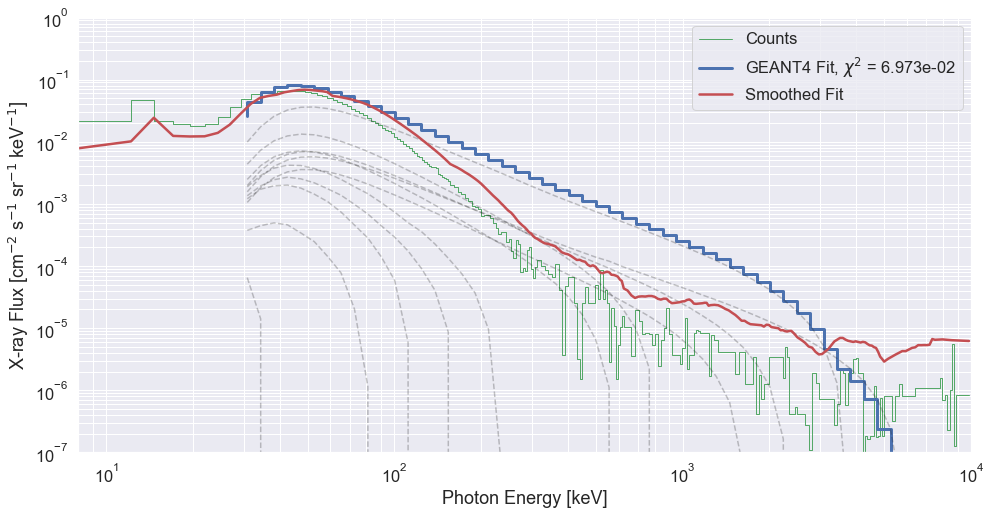

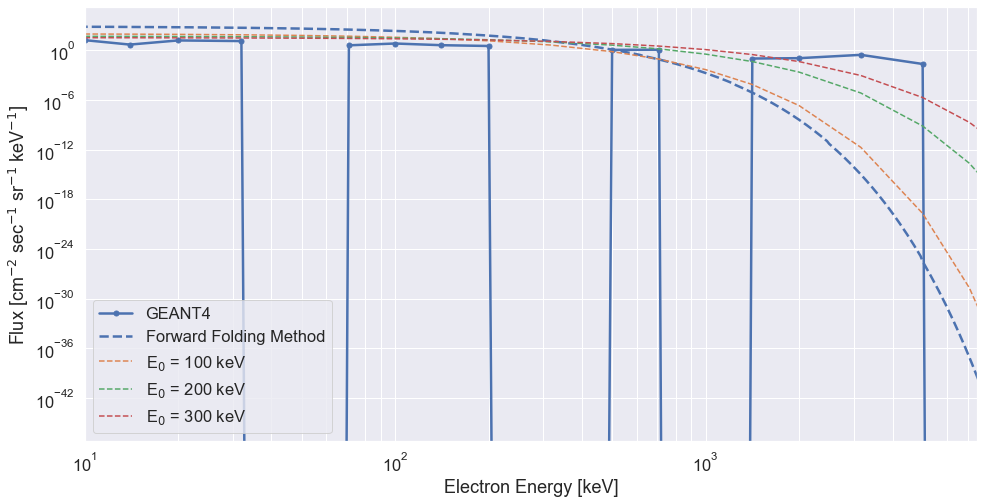

In [47]:
plt.figure(1, figsize=(16,8)); plt.grid(True, which='both')
plt.figure(2, figsize=(16,8)); plt.grid(True, which='both')

plt.figure(1);
plt.step(spec.E, spec.cts, c='g', label='Counts', linewidth=1)


newE = Earray[(Earray > limit) & (Earray < uLimit)]

ALT = 33

Nmc = 20
current_score = 1e5

f0 = 1e3
E0 = 100

coefArr  = np.zeros([Nmc, len(run_list[LOWLIMIT:RUNLIMIT])])
scores = np.zeros(Nmc)
for i in range(0, Nmc):
    
    #x0 = 1e-1 + 5e-2*np.random.rand(len(run_list[:RUNLIMIT]))
    x0 = f0/E0 * np.exp(-run_list[LOWLIMIT:RUNLIMIT] / E0) + \
            np.logspace(1, -1, len(run_list[LOWLIMIT:RUNLIMIT]))*\
            np.random.randn(len(run_list[LOWLIMIT:RUNLIMIT]))
    
    x0[x0 < 0] = 0
    tmp_X = minimize(minDiff, x0=x0, 
                     args=(ALT, 0, test_spectra, "LLS"),
                     tol=1e-15, 
                     bounds=bounds,
                     method='l-bfgs-b',
                     options={"maxiter": 750})
        
    scores[i]     = tmp_X.fun
    coefArr[i,:]  = tmp_X.x
    
    
    if current_score > tmp_X.fun:
        
        current_score = tmp_X.fun
        
        X = tmp_X
        
        coefs = tmp_X.x
    

coef = coefArr[np.argmin(scores),:]
    
print(X)

plt.figure(1)

# Generate spectrum estimate
Y = minDiff(coefs, ALT, 1)
#Y[Y < 1e-10] = np.nan

tmp = interpolateOntoGEANTenergy(spec.E, test_spectra)

Y[Y <= 0] = np.nan
chi2 = np.nansum( (Y - tmp)**2 / Y)
print(chi2)

plt.step(newE, Y, 'b-', linewidth=3, label='GEANT4 Fit, $\\chi^2$ = %.3e' % chi2);

for ind, item in enumerate(run_list[LOWLIMIT:RUNLIMIT]):
    
    plt.plot(newE, coefs[ind] * np.nansum(ang_avg[ALT-dh:ALT+dh, 
                                (Earray > limit) & 
                                (Earray < uLimit), 
                                ind], axis=0), 'k--', alpha=0.25)

#tmp = interpolateOntoBARRELenergy(newE, minDiff(X.x, ALT, 1))


plt.figure(1)
plt.loglog(spec.E, test_spectra, c='r', label='Smoothed Fit', linewidth=2.5);
plt.legend();
plt.xlabel('Photon Energy [keV]');
plt.ylabel('X-ray Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.xlim([0.8e1, 1e4]);
plt.ylim(1e-7, 1e0)


plt.figure(2)
plt.plot(run_list[LOWLIMIT:RUNLIMIT], coefs, '.-', 
         color='b', linewidth=2.5, markersize=10, label='GEANT4');
plt.loglog(b_inv.E, b_inv.C, '--', label='Forward Folding Method', linewidth=2.5)
plt.loglog(run_list, 1e4/100 * np.exp(-run_list/100), '--', label='E$_0$ = 100 keV')
plt.loglog(run_list, 1e4/200 * np.exp(-run_list/200), '--', label='E$_0$ = 200 keV')
plt.loglog(run_list, 1e4/300 * np.exp(-run_list/300), '--', label='E$_0$ = 300 keV')
plt.xlabel('Electron Energy [keV]');
plt.ylabel('Flux [cm$^{-2}$ sec$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.xlim(1e1, 7500);
plt.legend();